## Masked noise attenuation

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, KNNIndex, CustomIndex,
                            seismic_plot, spectrum_plot, merge_segy_files)

from unet import u_net, conv_block

%env CUDA_VISIBLE_DEVICES=1

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_VISIBLE_DEVICES=1


### Model configuration

In [308]:
# learning_rate=0.001

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    trace_in = tf.placeholder('float', shape=(None, 3000, 1), name='trace_in')
    trace_offset = tf.placeholder('float', shape=(None, 1), name='trace_offset')
    target = tf.placeholder('float', shape=(None, 3000, 1), name='target')
    balance = tf.placeholder('float', name='balance')
    balance_d = tf.placeholder('float', name='balance_d')
    learning_rate = tf.placeholder('float', name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    with tf.variable_scope("attention_scope"):
        attention = u_net(trace_in, depth=3, filters=8, kernel_size=3,
                          activation='elu', is_training=is_training)
        attention = conv_block(attention, 'c', filters=1, kernel_size=3)
        attention = conv_block(attention, 'ca', filters=1, kernel_size=3,
                               activation='sigmoid')
        print('attention', attention.get_shape())

        attention_sum = tf.reduce_sum(attention, axis=1)
        print('attention_sum', attention_sum.get_shape())
        
        sigm_x = tf.fill(tf.shape(attention)[:2], 0.0)
        sigm_x = tf.add(sigm_x, -tf.range(0, tf.cast(tf.shape(attention)[1], 'float'), dtype='float'))

        shift_in = tf.concat([attention_sum, trace_offset], axis=1)
        print('shift_in', shift_in.get_shape())
        shift_in = tf.layers.dense(shift_in, 16, activation=tf.nn.elu)
        shift_out = tf.layers.dense(shift_in, 2, activation=tf.nn.relu)
    
    sigm_x = tf.divide(tf.add(sigm_x, shift_out[:, :1]), 1 + shift_out[:, 1:2])
#     sigm_x = tf.add(sigm_x, attention_sum)
    
    attention_sigmoid = tf.expand_dims(tf.sigmoid(sigm_x), -1)
    print('attention_sigmoid', attention_sigmoid.get_shape())
    
    with tf.variable_scope("lift_scope"):
        lift_trace = u_net(trace_in, depth=4, filters=16, kernel_size=7,
                          activation='elu', is_training=is_training)
        lift_trace = conv_block(lift_trace, 'c', filters=1, kernel_size=3)
    print('lift', lift_trace.get_shape())
    
    predict = (tf.multiply(trace_in, attention_sigmoid) +
               tf.multiply(lift_trace, 1 - attention_sigmoid))
    loss = (tf.losses.absolute_difference(target, predict) +
            balance * tf.reduce_mean(1 - attention_sigmoid))
    
    gr_loss = tf.losses.absolute_difference(target, predict,
                                            reduction=tf.losses.Reduction.SUM,
                                            weights=(1 - attention_sigmoid) / tf.reduce_sum(1 - attention_sigmoid))


    optimizer = tf.train.AdamOptimizer(learning_rate)
    lift_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='lift_scope')
    attention_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='attention_scope')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step_attention = optimizer.minimize(loss, var_list=attention_vars)
        step_lift = optimizer.minimize(loss, var_list=lift_vars)
        step_gr_lift = optimizer.minimize(gr_loss, var_list=lift_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
#     saver.restore(sess, './attention_model.ckpt')

input (?, 3000, 1)
conv_block_0 (?, 3000, 8)
pool_0 (?, 1500, 8)
conv_block_1 (?, 1500, 16)
pool_1 (?, 750, 16)
conv_block_2 (?, 750, 32)
pool_2 (?, 375, 32)
bottom_conv_block_3 (?, 375, 64)
up_2 (?, 750, 64)
concat_3 (?, 750, 96)
up_conv_block_3 (?, 750, 32)
up_1 (?, 1500, 32)
concat_2 (?, 1500, 48)
up_conv_block_2 (?, 1500, 16)
up_0 (?, 3000, 16)
concat_1 (?, 3000, 24)
up_conv_block_1 (?, 3000, 8)
attention (?, 3000, 1)
attention_sum (?, 1)
shift_in (?, 2)
attention_sigmoid (?, 3000, 1)
input (?, 3000, 1)
conv_block_0 (?, 3000, 16)
pool_0 (?, 1500, 16)
conv_block_1 (?, 1500, 32)
pool_1 (?, 750, 32)
conv_block_2 (?, 750, 64)
pool_2 (?, 375, 64)
conv_block_3 (?, 375, 128)
pool_3 (?, 188, 128)
bottom_conv_block_4 (?, 188, 256)
up_3 (?, ?, 256)
concat_4 (?, 375, 384)
up_conv_block_4 (?, 375, 128)
up_2 (?, 750, 128)
concat_3 (?, 750, 192)
up_conv_block_3 (?, 750, 64)
up_1 (?, 1500, 64)
concat_2 (?, 1500, 96)
up_conv_block_2 (?, 1500, 32)
up_0 (?, 3000, 32)
concat_1 (?, 3000, 48)
up_conv_b

In [295]:
path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,36,1657,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,2,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,78,1655,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,3,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,79,1658,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,4,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy
111906,127,1654,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,5,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy


In [296]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = Dataset(tindex, SeismicBatch)
len(train_set)

34560

In [297]:
train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', 
                        tslice=np.arange(3000)))

train_pipeline = train_pipeline << train_set

In [356]:
loss_history = []
for _ in tqdm(range(500)):
    batch = train_pipeline.next_batch(batch_size=64, drop_last=True,
                                      n_enochs=None, shuffle=True)
    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    
    res = sess.run([
#                     loss, 
#                     step_attention,
#                     step_lift,
                    gr_loss, 
                    step_gr_lift
                   ],
                   feed_dict={trace_in: x,
                              target: y,
                              trace_offset: offset, 
                              is_training: True,
                              balance: 0.05,
                              learning_rate: 0.0001})
    loss_history.append(res[0])

100%|██████████| 500/500 [01:48<00:00,  4.60it/s]


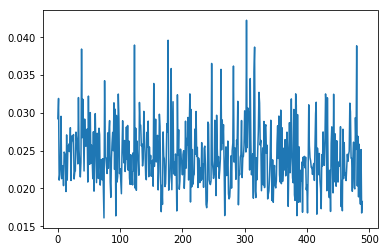

In [357]:
plt.plot(loss_history[10:])
plt.show()

In [358]:
i = 31
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000)))
    
    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    
    res = sess.run([attention, predict, lift_trace, attention_sigmoid, shift_out],
                   feed_dict={trace_in: x,
                              trace_offset: offset, 
                              is_training: False})
    
    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)

In [359]:
att = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out = np.squeeze(np.concatenate([t[1] for t in res_stack]))
out_lift = np.squeeze(np.concatenate([t[2] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[3] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))
shift_params = np.squeeze(np.concatenate([t[4] for t in res_stack]))

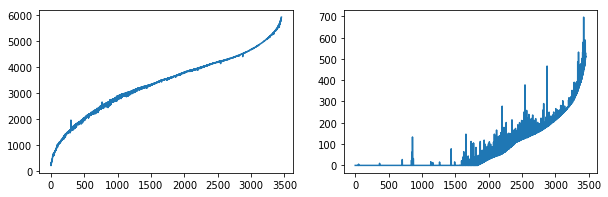

In [360]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(shift_params[:, 0])
ax[1].plot(shift_params[:, 1])
plt.show()

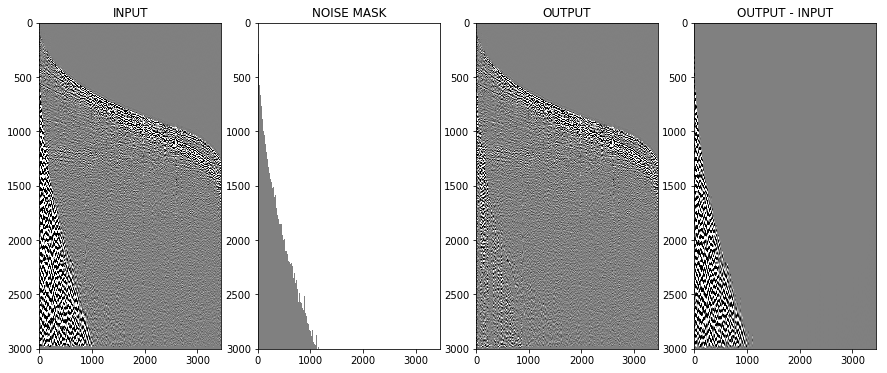

In [361]:
cv = 0.5
seismic_plot([raw, np.rint(att_sigm), out, out-raw], names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

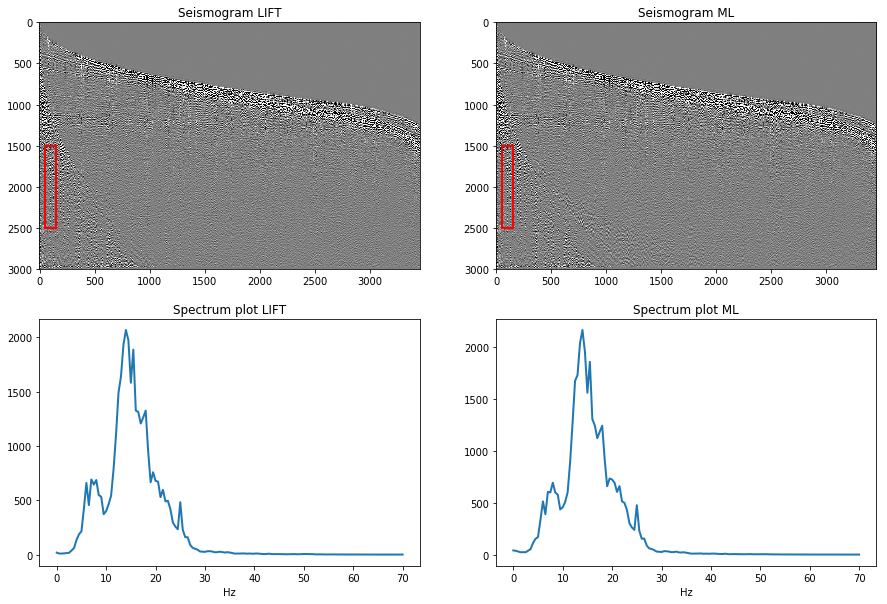

In [362]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(50, 150), slice(1500, 2500)),
                    rate=0.002, max_freq=70,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

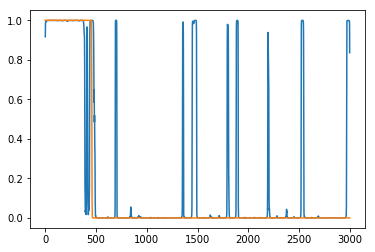

In [363]:
i = 20
plt.plot(att[i])
plt.plot(att_sigm[i])
plt.show()

## The same seismogram with hard sigmoid mask

In [287]:
i = 31
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000)))
    
    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    
    res = sess.run([attention, predict, lift_trace, attention_sigmoid, shift_out],
                   feed_dict={trace_in: x,
                              trace_offset: offset, 
                              is_training: False})
    
    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)

In [288]:
att = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out = np.squeeze(np.concatenate([t[1] for t in res_stack]))
out_lift = np.squeeze(np.concatenate([t[2] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[3] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))
# shift_params = np.squeeze(np.concatenate([t[4] for t in res_stack]))

In [289]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# ax[0].plot(shift_params[:, 0])
# ax[1].plot(shift_params[:, 1])
# plt.show()

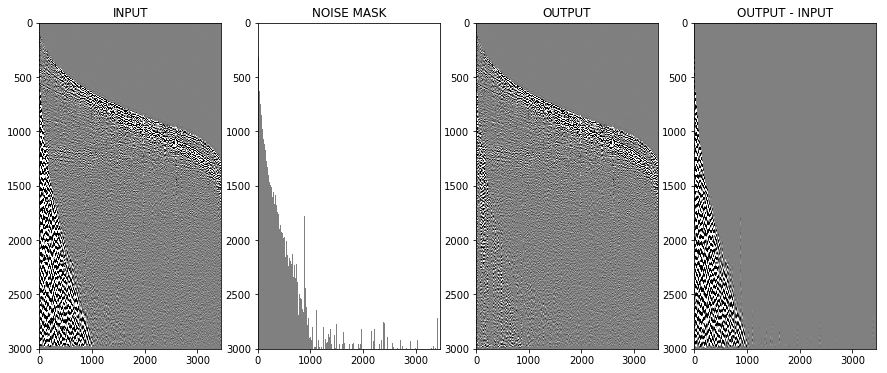

In [290]:
cv = 0.5
seismic_plot([raw, np.rint(att_sigm), out, out-raw], names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

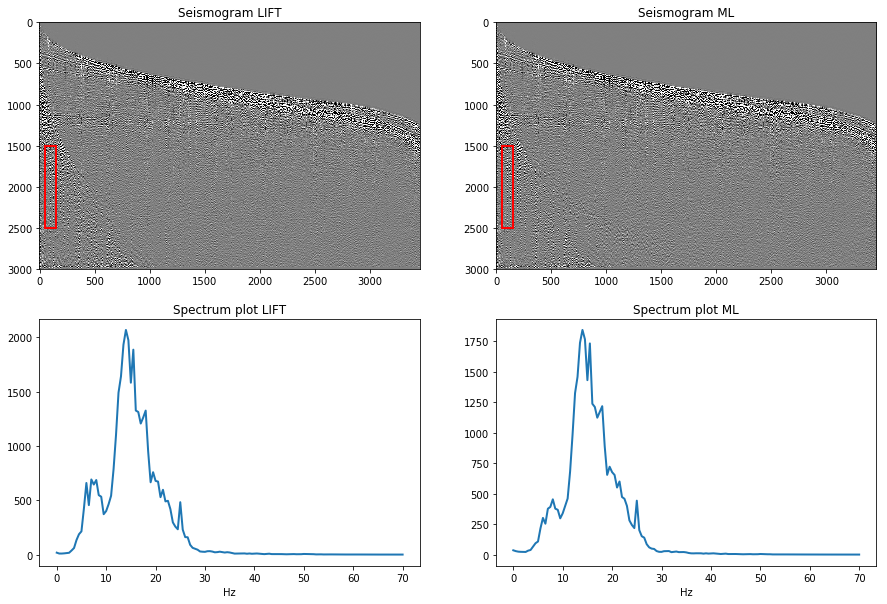

In [291]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(50, 150), slice(1500, 2500)),
                    rate=0.002, max_freq=70,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

In [242]:
import segyio

write_set = Dataset(TraceIndex(index), SeismicBatch)

batch_size = 2000

for k in range(1 + len(write_set) // batch_size):
    batch = (write_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', ), fmt='segy', tslice=np.arange(2992)))
    
    x = np.expand_dims(np.vstack(batch.raw), -1)
    res = sess.run([predict], feed_dict={trace_in: x, is_training: False})
    
    df = batch.index.get_df(reset=False)
    sort_by = batch.meta['raw']['sorting']
    if sort_by is not None:
        df = df.sort_values(by=sort_by)

    df = df.loc[batch.indices]
    df.reset_index(drop=batch.index.name is None, inplace=True)
    headers = list(set(df.columns.levels[0]))
    segy_headers = [h for h in headers if hasattr(segyio.TraceField, h)]
    df = df[segy_headers]
    df.columns = df.columns.droplevel(1)
    write_segy_file(res[0], df, batch.meta['raw']['samples'],
                   './dumps/' + str(k) + '.sgy')

In [243]:
merge_segy_files(path=os.path.join('./dumps/', '*sgy'),
                 output_path='/notebooks/egor/geolog/notebooks/merged.sgy')